In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats

# read in my plot parameters
pp = pd.read_csv('plotparams.csv',index_col=0)

# Notebook 4: comparison of F$_{\mathrm{rw}}$ and F$_{\mathrm{yw}}$

This notebook plots F$_{\mathrm{rw}}$ and F$_{\mathrm{yw}}$ vs flow rate (Q) and dissolved Si for study watersheds in the Luquillo Mountains. 

In [2]:
# read in all CQ data
cq = pd.read_csv('data/WRR2025_cq.csv',parse_dates=['datetime'],low_memory=False)
# read in only CQ data from the isotope sample period (2018-2020)
cq_sp = pd.read_csv('data/WRR2025_cq_sp.csv',index_col=0)
# read in Fyw results 
isotope_yw = pd.read_csv('tables/WRR2025_flowbins_output.csv',index_col=0)
# read in discharge bin medians
df_medians = pd.read_csv('data/WRR2025_discharge_medians.csv',index_col=0)

In [3]:
### put C data into fyw dataframe
sitelist = ['RI','QG','QS','QP','MPR','Q3']

dischargebottoms = [0,25,50,75,90]
dischargetops = [25,50,75,100,100]

elementlist=['SiO2']

for s in sitelist:

    for r in range(0,len(dischargebottoms)):
        
        indexstring = f'{s}_{dischargebottoms[r]}-{dischargetops[r]}%'
        
        query = f'(site == "{s}") & (rank_sp >={dischargebottoms[r]}) & (rank_sp <{dischargetops[r]})'
        boolsubset = cq_sp.query(query)
        
        if len(boolsubset)>0:
            for e in elementlist:
                isotope_yw.loc[indexstring,e] = np.nanmean(boolsubset[e])
                isotope_yw.loc[indexstring,f'{e}_stdev'] = np.nanstd(boolsubset[e])
                isotope_yw.loc[indexstring,f'{e}_stderr'] = np.nanstd(boolsubset[e])/len(boolsubset)

In [4]:
### get means of F_rw for discharge bins

## indices for Monte Carlo runs
longindices = [str(i) for i in range(0,9999)] # this is 9999 for 10,000 MC runs 

## set discharge bins
# watersheds RI, QG, and MPR have been sampled at very high discharge, so include top 1% of discharge (99-100%)
dischargebottoms_long_full = [0,25,50,60,70,80,90,99]
dischargetops_long_full = [25,50,60,70,80,90,99,100]

## watersheds QS, QP and Q3 have only been sampled weekly, and the top 1% of discharge is not sampled.
# so, remove top 1% and just have top 10%
dischargebottoms_long_alt = [0,25,50,60,70,80,90]
dischargetops_long_alt = [25,50,60,70,80,90,100]

# this dataframe stores binned Frw estimates
solute_rw = pd.DataFrame()

for s in sitelist:
    if s in ['RI','QG','MPR']:
        dischargebottoms_long = dischargebottoms_long_full
        dischargetops_long = dischargetops_long_full
    else:
        dischargebottoms_long = dischargebottoms_long_alt
        dischargetops_long = dischargetops_long_alt 

    templong = pd.read_csv(f'EMMAresults/{s}_Na-Ca-Mg-Cl_long.csv',parse_dates=['datetime'],index_col=0,low_memory=False)

    for r in range(0,len(dischargebottoms_long)):
        indexstring = f'{s}_{dischargebottoms_long[r]}-{dischargetops_long[r]}%'

        query = f'(rank >={dischargebottoms_long[r]}) & (rank <{dischargetops_long[r]})'
        boolsubset = templong.query(query)

        templong_binned = np.matrix(boolsubset.loc[:,longindices])

        tempmeanlist = []

        for i in range(0,999): # generate 1000 means by resampling random 
            mcsamples = np.random.randint(0,999,len(templong_binned))
            mc_temp = templong_binned[range(0,len(templong_binned)),mcsamples]

            mc_temp[mc_temp<0] = 0 # negative Frw (non-physical) to 0
            mc_temp[mc_temp>1] = 1 # Frw>1 (also non-physical) to 1

            tempmeanlist.append(np.mean(mc_temp))

        solute_rw.loc[indexstring,'site'] = s
        solute_rw.loc[indexstring,'bin'] = f'{dischargebottoms_long[r]}-{dischargetops_long[r]}'
     
        solute_rw.loc[indexstring,'frw_mean'] = np.mean(tempmeanlist)
        solute_rw.loc[indexstring,'frw_5'] = np.percentile(tempmeanlist,5)
        solute_rw.loc[indexstring,'frw_95'] = np.percentile(tempmeanlist,95)

In [5]:
### get Frw for sampling period (2018-2020) to directly compare to Fyw from isotopes
dischargebottoms_sp = [0,25,50,75,90]
dischargetops_sp = [25,50,75,100,100]

# this dataframe stores binned Frw estimates for sampling period 2018-2020
solute_rw_sp = pd.DataFrame()

sitelist_spq = ['RI','QG','MPR','QS','QP'] # no Q3, no discharge for sampling period

for s in sitelist_spq:
    templong = pd.read_csv(f'EMMAresults/{s}_Na-Ca-Mg-Cl_long.csv',parse_dates=['datetime'],index_col=0,low_memory=False)
    templong_sp = templong.loc[templong['datetime']>pd.Timestamp(2018,4,1)]

    for r in range(0,len(dischargebottoms)):
        indexstring = f'{s}_{dischargebottoms[r]}-{dischargetops[r]}%'

        query = f'(rank_sp >={dischargebottoms[r]}) & (rank_sp <{dischargetops[r]})'
        boolsubset = templong_sp.query(query)

        templong_binned = np.matrix(boolsubset.loc[:,longindices])

        tempmeanlist = []

        for i in range(0,999): # generate 1000 means by resampling random 
            mcsamples = np.random.randint(0,999,len(templong_binned))
            mc_temp = templong_binned[range(0,len(templong_binned)),mcsamples]

            mc_temp[mc_temp<0] = 0 # project negative Frw (non-physical) to 0
            mc_temp[mc_temp>1] = 1 # projet Frw>1 (also non-physical)

            tempmeanlist.append(np.mean(mc_temp))

        solute_rw_sp.loc[indexstring,'site'] = s
        solute_rw_sp.loc[indexstring,'bin'] = f'{dischargebottoms[r]}-{dischargetops[r]}'
    
        solute_rw_sp.loc[indexstring,'frw_mean'] = np.mean(tempmeanlist)
        solute_rw_sp.loc[indexstring,'frw_5'] = np.percentile(tempmeanlist,5)
        solute_rw_sp.loc[indexstring,'frw_95'] = np.percentile(tempmeanlist,95)

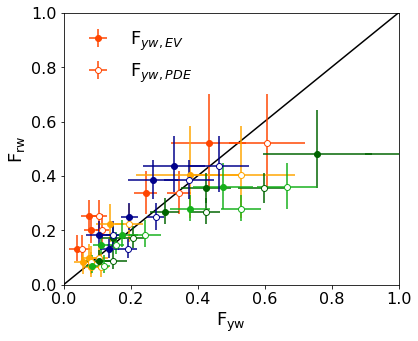

In [6]:
## plot solute and isotope fractions together

plt.rcParams.update({'font.size': 18,
                    'axes.labelsize': 18,
                    'xtick.labelsize':16,
                    'ytick.labelsize':16})

# merge isotopes Fyw and solute Frw
compare = isotope_yw.merge(solute_rw_sp[['frw_mean','frw_5','frw_95']], left_index=True, right_index=True)

fig,ax=plt.subplots(1,1,figsize=(6,5))

for s in sitelist:
    tempdf = compare.loc[compare['site']==s,:]
    plt.errorbar(tempdf['ampratio'],tempdf['frw_mean'],c=pp.color[s],xerr=tempdf['ampratio_error'],
                 yerr=np.array([np.array(tempdf['frw_mean']-tempdf['frw_5']),np.array(tempdf['frw_95']-tempdf['frw_mean'])]),ls='',marker='o')

    plt.errorbar(tempdf['ampratio']*3.511/2.5,tempdf['frw_mean'],markerfacecolor='w',color=pp.color[s],xerr=tempdf['ampratio_error'],
                 yerr=np.array([np.array(tempdf['frw_mean']-tempdf['frw_5']),np.array(tempdf['frw_95']-tempdf['frw_mean'])]),ls='',marker='o')

# plot limits, labels, legend
plt.plot([0,1],[0,1],c='k',zorder=0,label='_nolegend_')
plt.xlim([0,1])
plt.ylim([0,1])
    
plt.xlabel('F$_{\mathrm{yw}}$')
plt.ylabel('F$_{\mathrm{rw}}$')

plt.legend(['F$_{yw,EV}$','F$_{yw,PDE}$'],frameon=False,fontsize=18)

In [7]:
### put Si and Q data into solute frw dataframe
elementlist = ['SiO2']
for s in sitelist:
    if s in ['RI','QG','MPR']:
        dischargebottoms_long = dischargebottoms_long_full
        dischargetops_long = dischargetops_long_full
    else:
        dischargebottoms_long = dischargebottoms_long_alt
        dischargetops_long = dischargetops_long_alt 

    # get median Q concentrtion for that bin
    indexstring = [f'{s}_{dischargebottoms_long[r]}-{dischargetops_long[r]}%' for r in range(0,len(dischargebottoms_long))]
    medians_indexstring = [f'{dischargebottoms_long[r]}-{dischargetops_long[r]}' for r in range(0,len(dischargebottoms_long))]
    solute_rw.loc[indexstring,'Qmed'] = df_medians.loc[s,medians_indexstring].values
    
    # get mean solute Si concentration for that bin
    for r in range(0,len(dischargebottoms_long)):

        indexstring = f'{s}_{dischargebottoms_long[r]}-{dischargetops_long[r]}%'
        query = f'(site == "{s}") & (rank >={dischargebottoms_long[r]}) & (rank <{dischargetops_long[r]})'
        boolsubset = cq.query(query)

        if len(boolsubset)>10:
            for e in elementlist:
                solute_rw.loc[indexstring,e] = np.nanmean(boolsubset[e])
                solute_rw.loc[indexstring,f'{e}_stdev'] = np.nanstd(boolsubset[e])
                solute_rw.loc[indexstring,f'{e}_stderr'] = np.nanstd(boolsubset[e])/len(boolsubset)

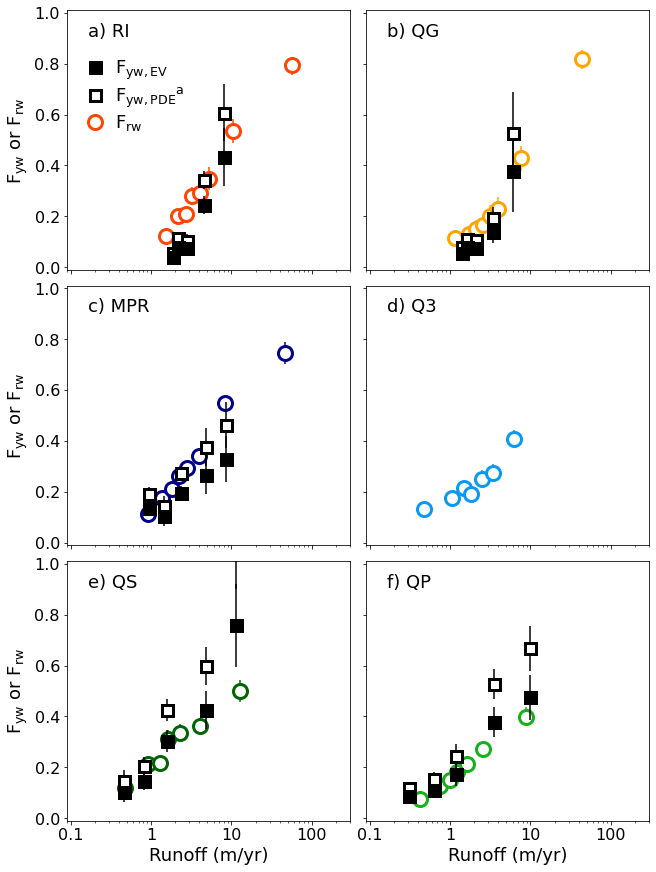

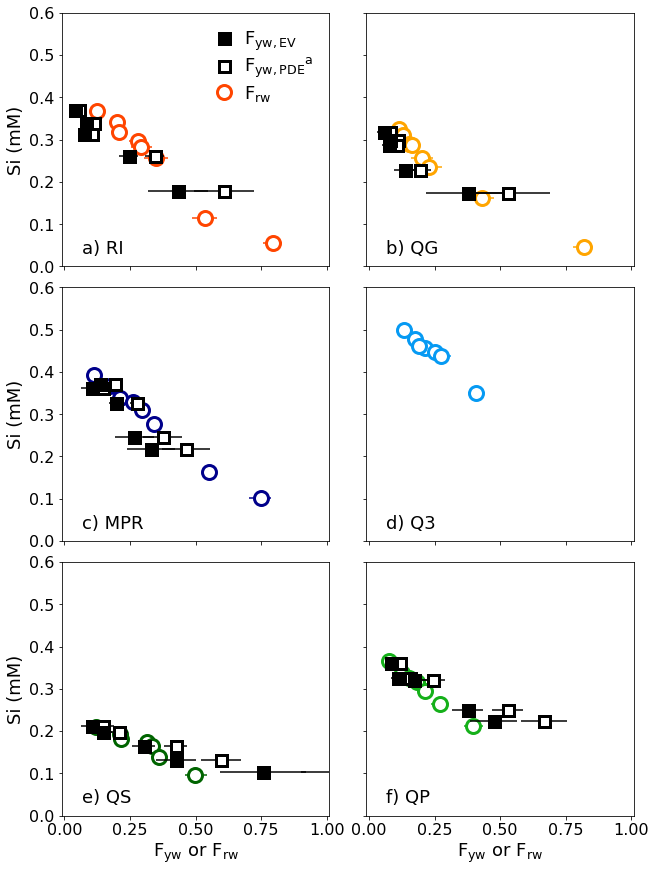

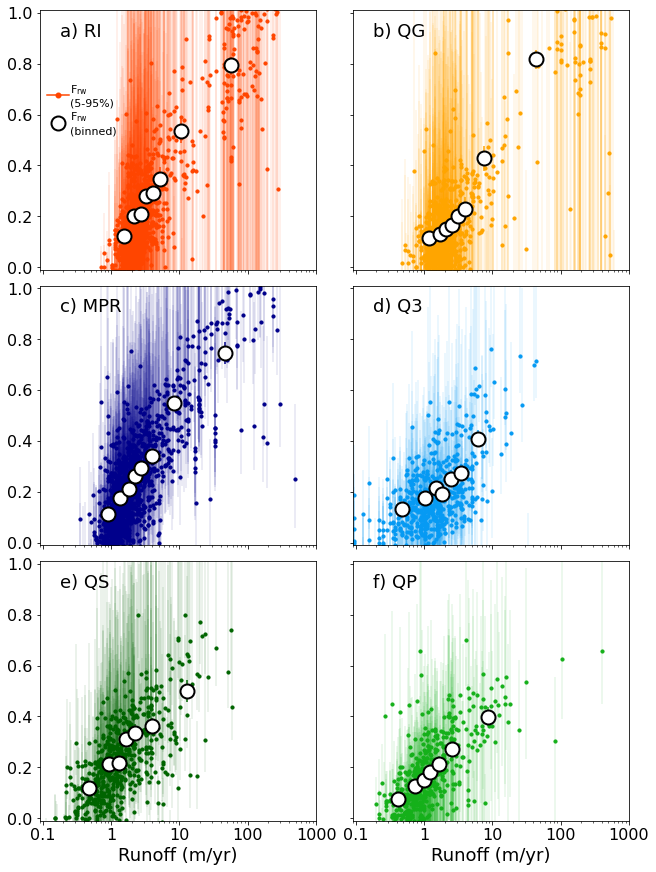

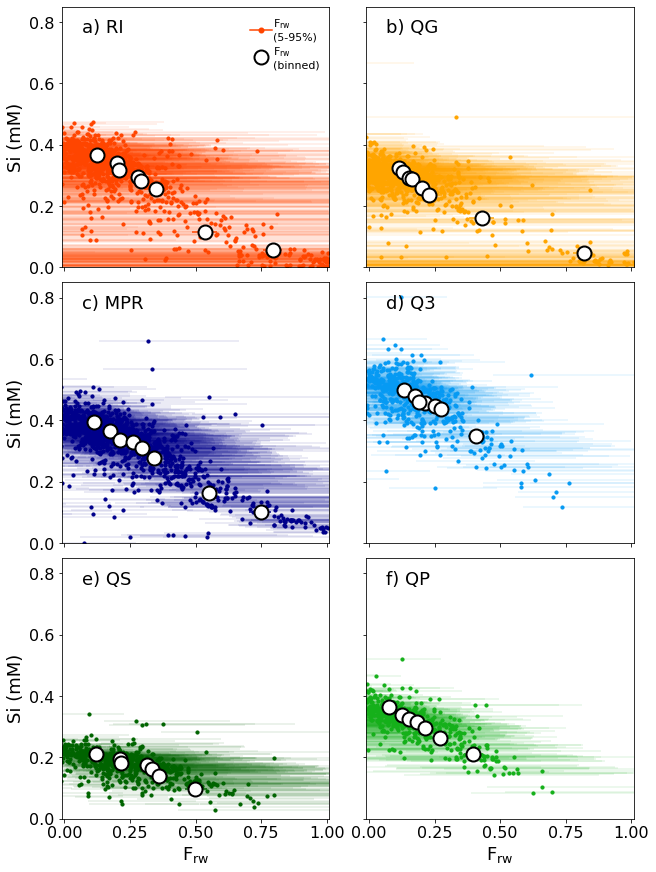

In [8]:
plt.rcParams.update({'font.size': 18,
                    'axes.labelsize': 18,
                    'xtick.labelsize':16,
                    'ytick.labelsize':16})
smallms=14

# binned
fig,ax = plt.subplots(3,2,sharey=True,figsize = (9,12),constrained_layout=True,sharex=True) # Fyw-Q
fig2,ax2 = plt.subplots(3,2,sharey=True,figsize = (9,12),constrained_layout=True,sharex=True) # Si-Fyw
ax = ax.flatten()
ax2 = ax2.flatten()

# scatter all 
fig3,ax3 = plt.subplots(3,2,sharey=True,figsize = (9,12),constrained_layout=True,sharex=True) # Fyw-Q
fig4,ax4 = plt.subplots(3,2,sharey=True,figsize = (9,12),constrained_layout=True,sharex=True) # Si-Fyw
ax3 = ax3.flatten()
ax4 = ax4.flatten()

output_intercepts = pd.DataFrame()
output_intercepts['site'] = np.repeat(sitelist,3)
output_intercepts['method'] = ['solute','iso','iso_scholl']*6


plotelement = 'SiO2'
e = 'SiO2'
e_mm = 60 # molar mass (I like mM in my plots)

sitelist = ['RI','QG','MPR','Q3','QS','QP']

for i,site in enumerate(sitelist):
    # get binned EMMA (solute) data. make temp dataset and drop nas so that we can do linear regression later
    tempsolute = solute_rw.loc[solute_rw['site']==site,:]
    tempsolute = tempsolute.dropna(subset=['frw_mean','frw_5','frw_95',e,f'{e}_stderr','Qmed'])

    solute_frw = tempsolute['frw_mean']#tempsolute.loc[tempsolute.loc[:,'site']==site,'F1_med']+tempsolute.loc[tempsolute.loc[:,'site']==site,'F2_med']
    solute_frw_5 = tempsolute['frw_5']#tempsolute.loc[tempsolute.loc[:,'site']==site,'F1_med']+tempsolute.loc[tempsolute.loc[:,'site']==site,'F2_med']
    solute_frw_95 = tempsolute['frw_95']#tempsolute.loc[tempsolute.loc[:,'site']==site,'F1_med']+tempsolute.loc[tempsolute.loc[:,'site']==site,'F2_med']
    solute_conc = tempsolute[e]/e_mm
    solute_conc_error = tempsolute[f'{e}_stderr']/e_mm  
    solute_qs = tempsolute['Qmed']   
    
    # compute solute-based C-Frw slope
    solute_slope, solute_intercept, solute_r_value, solute_p_value, solute_std_err = stats.linregress(solute_frw,solute_conc)
    
    ## all points scattered EMMA (solute) data
    tempsolute_scatter = pd.read_csv(f'EMMAresults/{site}_Na-Ca-Mg-Cl.csv',parse_dates=['datetime'],index_col=0)
    
    solute_frw_scatter = tempsolute_scatter['F1_med']
    solute_frw_5_scatter = tempsolute_scatter['F1_5']
    solute_frw_95_scatter = tempsolute_scatter['F1_95']
    solute_conc_scatter = tempsolute_scatter[e]/e_mm
    solute_qs_scatter = tempsolute_scatter['discharge(m/yr)']

    
    ## isotope data - exclude Q3 here
    if site != 'Q3':
        iso_fyw = isotope_yw.loc[isotope_yw['site']==site,'ampratio']
        iso_fyw_scholl =  isotope_yw.loc[isotope_yw['site']==site,'ampratio']*3.511/2.5
        iso_fyw_error = isotope_yw.loc[isotope_yw['site']==site,'ampratio_error']
        iso_conc = isotope_yw.loc[isotope_yw['site']==site,e]/e_mm
        iso_conc_error = isotope_yw.loc[isotope_yw['site']==site,f'{e}_stderr']/e_mm  
        iso_qs = isotope_yw.loc[isotope_yw['site']==site,'Qmed']

        # compute isotope-based C-Fyw slope
        iso_slope, iso_intercept, iso_r_value, iso_p_value, iso_std_err = stats.linregress(iso_fyw,iso_conc)
        iso_slope_scholl, iso_intercept_scholl, iso_r_value_scholl, iso_p_value_scholl, iso_std_err_scholl = stats.linregress(iso_fyw_scholl,iso_conc)
        
    # save intercepts when regressing Si against Fyw, Frw
    output_intercepts.loc[((output_intercepts['site']==site) & (output_intercepts['method']=='iso')),f'{e}_old'] = iso_intercept
    output_intercepts.loc[((output_intercepts['site']==site) & (output_intercepts['method']=='iso')),f'{e}_young']  = iso_slope+iso_intercept

    output_intercepts.loc[((output_intercepts['site']==site) & (output_intercepts['method']=='iso_scholl')),f'{e}_old'] = iso_intercept_scholl
    output_intercepts.loc[((output_intercepts['site']==site) & (output_intercepts['method']=='iso_scholl')),f'{e}_young']  = iso_slope_scholl+iso_intercept_scholl

    output_intercepts.loc[((output_intercepts['site']==site) & (output_intercepts['method']=='solute')),f'{e}_old'] = solute_intercept
    output_intercepts.loc[((output_intercepts['site']==site) & (output_intercepts['method']=='solute')),f'{e}_young']  = solute_slope+solute_intercept

    ## now plot everything
    ## Fyw-Q solute 
    ## binned
    # binned Fyw-Q
    ax[i].errorbar(solute_qs,solute_frw,yerr=[np.array(solute_frw-solute_frw_5),np.array(solute_frw_95-solute_frw)],
                    zorder=1,c=pp.color[site],marker='o',markeredgecolor=pp.color[site],markerfacecolor='white',ms=smallms,ls='',markeredgewidth=3)

    # binned C-Fyw 
    ax2[i].errorbar(solute_frw,solute_conc,xerr=[np.array(solute_frw-solute_frw_5),np.array(solute_frw_95-solute_frw)],
                   yerr=solute_conc_error,zorder=1,marker='o',c=pp.color[site],markeredgecolor=pp.color[site],
                   markerfacecolor='white',ls='',ms=smallms,markeredgewidth=3)

    # scatter Fyw-Q
    ax3[i].scatter(solute_qs_scatter,solute_frw_scatter ,s=10,zorder=1,c=pp.color[site],alpha=1)
    ax3[i].errorbar(solute_qs_scatter,solute_frw_scatter ,zorder=1,c=pp.color[site],alpha=0.1,ls='',yerr=np.array([np.array(solute_frw_scatter-solute_frw_5_scatter),np.array(solute_frw_95_scatter-solute_frw_scatter)]))

    # scatter C-Fyw
    ax4[i].scatter(solute_frw_scatter,solute_conc_scatter ,s=10,zorder=1,c=pp.color[site],alpha=1)
    ax4[i].errorbar(solute_frw_scatter,solute_conc_scatter ,zorder=1,c=pp.color[site],alpha=0.1,ls='',xerr=np.array([np.array(solute_frw_scatter-solute_frw_5_scatter),np.array(solute_frw_95_scatter-solute_frw_scatter)]))

    # binned Fyw-Q
    ax3[i].errorbar(solute_qs,solute_frw,yerr=[np.array(solute_frw-solute_frw_5),np.array(solute_frw_95-solute_frw)],
                    zorder=1,c=pp.color[site],marker='o',markeredgecolor='k',markerfacecolor='white',ms=smallms,ls='',markeredgewidth=2)
    # binned C-Fyw
    ax4[i].errorbar(solute_frw,solute_conc,xerr=[np.array(solute_frw-solute_frw_5),np.array(solute_frw_95-solute_frw)],
                   yerr=solute_conc_error,zorder=1,marker='o',c=pp.color[site],markeredgecolor='k',
                   markerfacecolor='white',ls='',ms=smallms,markeredgewidth=2)
    
    if site != 'Q3':
        # Fyw-Q iso binned
        ax[i].errorbar(iso_qs,iso_fyw_scholl,yerr=iso_fyw_error,marker='s',c='k',markeredgecolor='k',markerfacecolor='white',markeredgewidth=3,ms=smallms-3,zorder=3,ls='')
        ax[i].errorbar(iso_qs,iso_fyw,yerr=iso_fyw_error,marker='s',c='k',markeredgewidth=3,ms=smallms-3,zorder=3,ls='')

        # C-Fyw iso binned
        ax2[i].errorbar(iso_fyw_scholl,iso_conc,xerr=iso_fyw_error,yerr=iso_conc_error,marker='s',c='k',markeredgecolor='k',markerfacecolor='white',markeredgewidth=3,ms=smallms-3,zorder=3,ls='')
        ax2[i].errorbar(iso_fyw,iso_conc,xerr=iso_fyw_error,yerr=iso_conc_error,marker='s',c='k',markeredgewidth=3,ms=smallms-3,zorder=3,ls='')

## ticks, limits, labels, legends
import matplotlib.ticker as ticker
for i in [0,1,2,3,4,5]:
    # ax2[i].set_xticks([])

    min_loc = ticker.LogLocator(subs='all',numticks=100)
    ax[i].xaxis.set_minor_locator(min_loc)
    ax3[i].xaxis.set_minor_locator(min_loc)
        
# binned lims
ax[0].set_xscale('log')
ax[0].set_ylim([-0.01,1.01])
[ax[i].set_xlim([0.09,300]) for i in range(0,5)]
ax2[0].set_xlim([-0.01,1.01])
ax2[0].set_ylim([0,0.6])
[ax[i].set_xticks([0.1,1,10,100]) for i in range(0,5)]
ax[4].set_xticklabels([0.1,1,10,100])    
ax[5].set_xticklabels([0.1,1,10,100])    

# scatter all lims
ax3[0].set_xscale('log')
ax3[0].set_ylim([-0.01,1.01])
[ax3[i].set_xlim([0.09,1000]) for i in range(0,5)]
ax4[0].set_xlim([-0.01,1.01])
ax4[0].set_ylim([0,0.85])
[ax3[i].set_xticks([0.1,1,10,100,1000]) for i in range(0,5)]
ax3[4].set_xticklabels([0.1,1,10,100,1000])    
ax3[5].set_xticklabels([0.1,1,10,100,1000])  

# make legend

scatter_legend_elements = [
               Line2D([0], [0],ls='-', marker='o', color=pp.color['RI'], label='F$_{\mathrm{rw}}$\n(5-95%)',
                     alpha=1,markersize=4,markeredgewidth=2),
               Line2D([0], [0],ls='', marker='o', color='k', label='F$_{\mathrm{rw}}$\n(binned)',
                          markerfacecolor='white',markersize=smallms,markeredgewidth=2),]

legend_elements = [Line2D([0], [0],ls='', marker='s', color='black', label='F$_{\mathrm{yw, EV}}$',
                      markerfacecolor='black',markersize=smallms-3,markeredgewidth=3),
               Line2D([0], [0],ls='', marker='s', markeredgecolor='k',markerfacecolor='white', label='F$_{\mathrm{yw, PDE}}$'+'$^{\mathrm{a}}$',
                      markersize=smallms-3,markeredgewidth=3),
               Line2D([0], [0],ls='', marker='o', color=pp.color['RI'], label='F$_{\mathrm{rw}}$',
                      markerfacecolor='white',markersize=smallms,markeredgewidth=3)]

ax[0].legend(handles=legend_elements,loc=[0.01,0.5],ncol=1,frameon=False,labelspacing=0.2,handletextpad=0.1)
ax2[0].legend(handles=legend_elements,loc='upper right',ncol=1,frameon=False,labelspacing=0.2,handletextpad=0.1)
ax3[0].legend(handles=scatter_legend_elements,loc=[0.01,0.5],ncol=1,frameon=False,labelspacing=0.2,handletextpad=0.1,fontsize=11)
ax4[0].legend(handles=scatter_legend_elements,loc='upper right',ncol=1,frameon=False,labelspacing=0.2,handletextpad=0.1,fontsize=11)

# axis labels
ax[4].set_xlabel('Runoff (m/yr)')
ax[5].set_xlabel('Runoff (m/yr)')

ax[0].set_ylabel('F$_{\mathrm{yw}}$ or F$_{\mathrm{rw}}$')
ax[2].set_ylabel('F$_{\mathrm{yw}}$ or F$_{\mathrm{rw}}$')
ax[4].set_ylabel('F$_{\mathrm{yw}}$ or F$_{\mathrm{rw}}$')

ax2[4].set_xlabel('F$_{\mathrm{yw}}$ or F$_{\mathrm{rw}}$')
ax2[5].set_xlabel('F$_{\mathrm{yw}}$ or F$_{\mathrm{rw}}$')

ax2[0].set_ylabel('Si (mM)')
ax2[2].set_ylabel('Si (mM)')
ax2[4].set_ylabel('Si (mM)')

# scatter plots axis labels
ax3[4].set_xlabel('Runoff (m/yr)')
ax3[5].set_xlabel('Runoff (m/yr)')

ax4[0].set_ylabel('F$_{\mathrm{rw}}$')
ax4[2].set_ylabel('F$_{\mathrm{rw}}$')
ax4[4].set_ylabel('F$_{\mathrm{rw}}$')

ax4[4].set_xlabel('F$_{\mathrm{rw}}$')
ax4[5].set_xlabel('F$_{\mathrm{rw}}$')

ax4[0].set_ylabel('Si (mM)')
ax4[2].set_ylabel('Si (mM)')
ax4[4].set_ylabel('Si (mM)')

# plot labels
letters = ['a)','b)','c)','d)','e)','f)']
sitelist = ['RI','QG','MPR','Q3','QS','QP']

for i,s in enumerate(sitelist):
    
    temptext = letters[i]+' '+s
    ax[i].text(0.075,0.90,temptext,transform=ax[i].transAxes,horizontalalignment='left')
    ax2[i].text(0.075,0.05,temptext,transform=ax2[i].transAxes,horizontalalignment='left')

    ax3[i].text(0.075,0.90,temptext,transform=ax3[i].transAxes,horizontalalignment='left')
    ax4[i].text(0.075,0.90,temptext,transform=ax4[i].transAxes,horizontalalignment='left')
    


fig.savefig('plots//Fig7_Fyw_Q.pdf')
fig2.savefig('plots//Fig8_C_Fyw.pdf')
fig3.savefig('plots//FigS10_Fyw_Q.pdf')
fig4.savefig('plots//FigS11_C_Fyw.pdf')

In [9]:
# save intercepts
output_intercepts.to_csv('tables/WRR2025_Table4.csv')